In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [3]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [104]:
both_res = parse_results('grid_search_results/both_detail_100.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]

In [105]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((72, 3, 100), (72, 3, 100))

In [106]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [107]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[1, 2, 4, 8]
[16, 32, 48, 64, 96, 128]
[0.02]
[0.003, 0.004, 0.005]


In [108]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [109]:
num_hidden_layers, layer_size

(array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8,
        8, 8]),
 array([ 16,  32,  48,  64,  96, 128,  16,  32,  48,  64,  96, 128,  16,
         32,  48,  64,  96, 128,  16,  32,  48,  64,  96, 128]))

--------------- Weight Decay: 0.003 ---------------


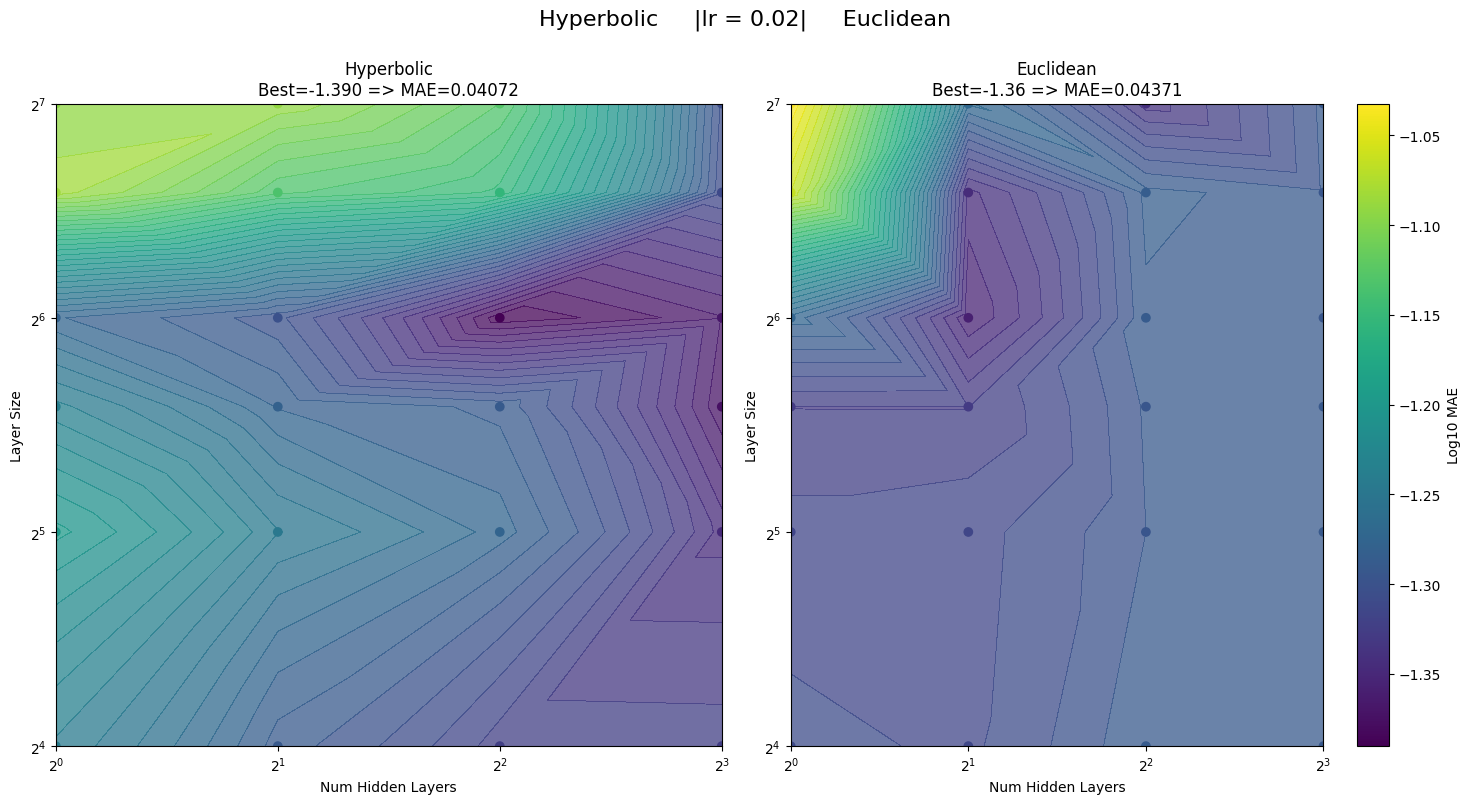

--------------- Weight Decay: 0.004 ---------------


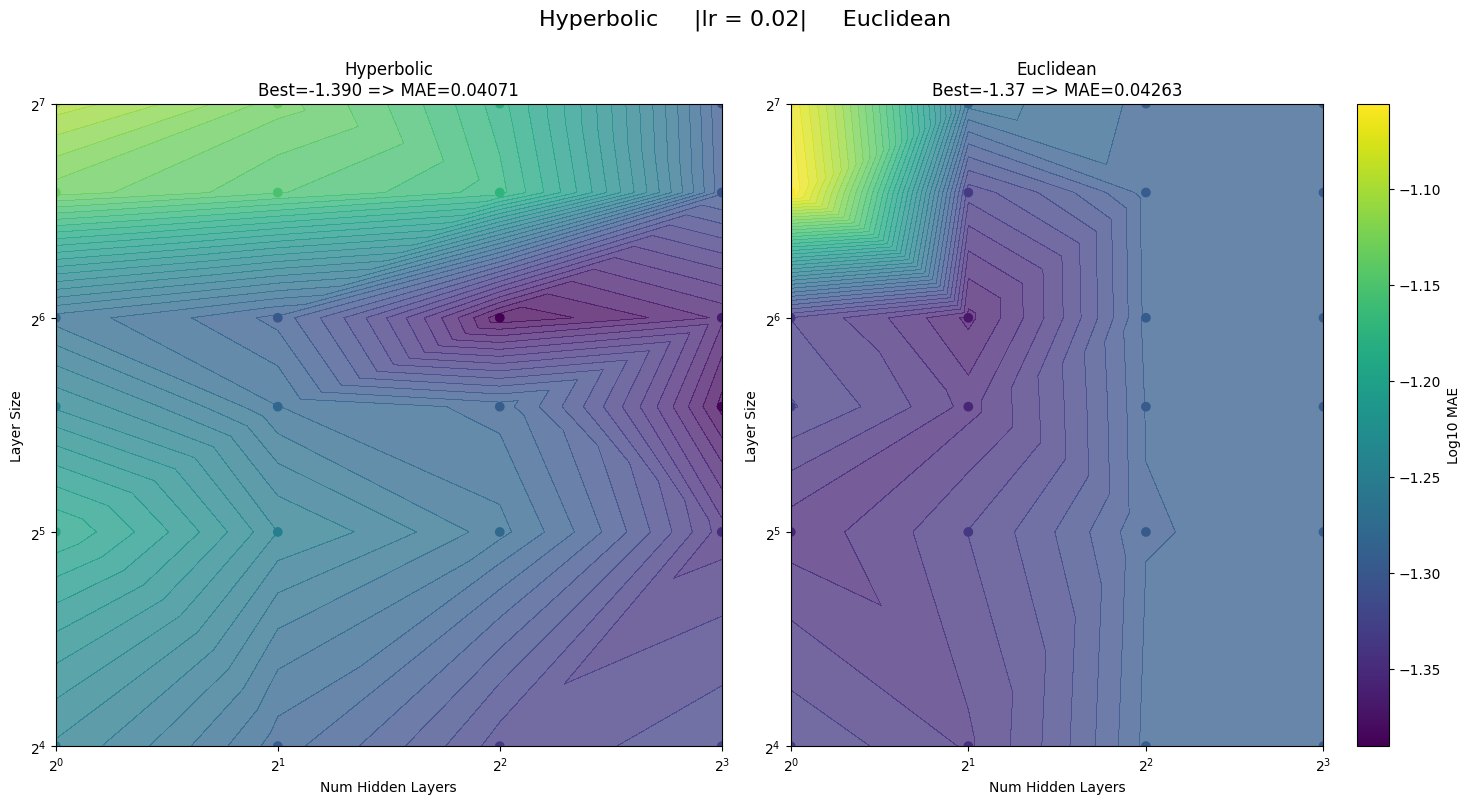

--------------- Weight Decay: 0.005 ---------------


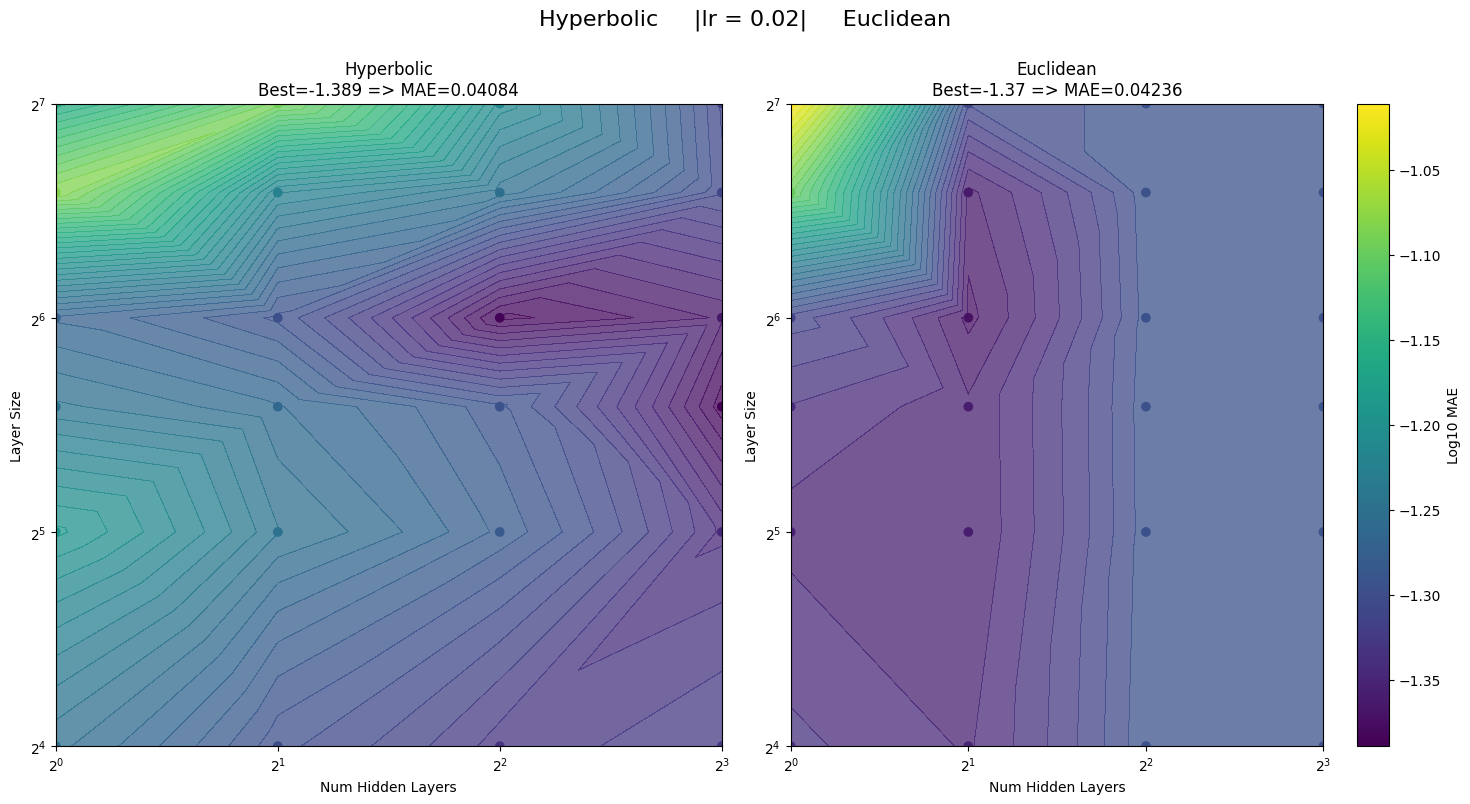

In [115]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = np.log10(hyp_values_wd.mean(axis=1)[:,89].reshape(-1,len(LR))[:,i])
        euc_data = np.log10(euc_values_wd.mean(axis=1)[:,29].reshape(-1,len(LR))[:,i])

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic\nBest={np.min(hyp_data):.3f} => MAE={np.power(10, np.min(hyp_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='Log10 MAE')


        plt.title(f'Euclidean\nBest={np.min(euc_data):.3} => MAE={np.power(10, np.min(euc_data)):.5f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>Best Runs:</h3>
Checked every 100 epochs, bc taking the min epoch gives advantage to unstable training.

Hyperbolic:  MAE = 0.040 (80 EPOCHS)
- num-l: 4
- size-l: 64
- lr: 0.02
- wd: 0.004

Euclidean:  MAE = (X EPOCHS)
- num-l: 2
- size-l: 64
- lr: 0.02
- wd: 0.005

In [102]:
print(list(hyp_values.mean(axis=1)[:,89].argsort()[:5]))
print(list(euc_values.mean(axis=1)[:,29].argsort()[:5]))

[23, 32, 41, 40, 31]
[25, 14, 4, 1, 12]


In [96]:
for k in range(40):
    print(np.sort(hyp_values.mean(axis=1)[:,k*10+9])[:10].mean())

0.10333306113333333
0.06301885976666667
0.0530460134
0.046712904
0.04577615746666667
0.0453469805
0.04503621333333334
0.044719727900000006
0.044640783399999995
0.04462080303333334
0.0445527474
0.04451099306666667
0.0444507539
0.0444127473
0.04442717526666666
0.04442726283333333
0.04447026913333334
0.044495633433333334
0.04452075306666666
0.0445111403
0.044502169800000005
0.044518249733333334
0.044477720000000005
0.04440861526666666
0.04438927673333334
0.04439691689999999
0.0444057333
0.04440964373333333
0.04437097029999999
0.04434950573333333
0.044342013400000005
0.04433899536666667
0.04433619403333334
0.044332344233333335
0.04431576276666667
0.044302580400000006
0.04432069870000001
0.044377375133333334
0.0444229295
0.04444333063333333


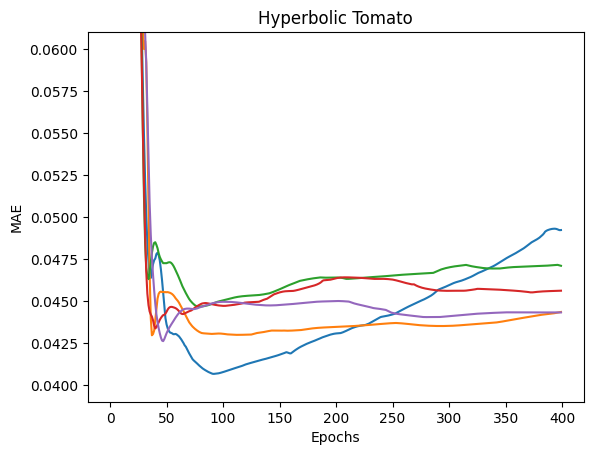

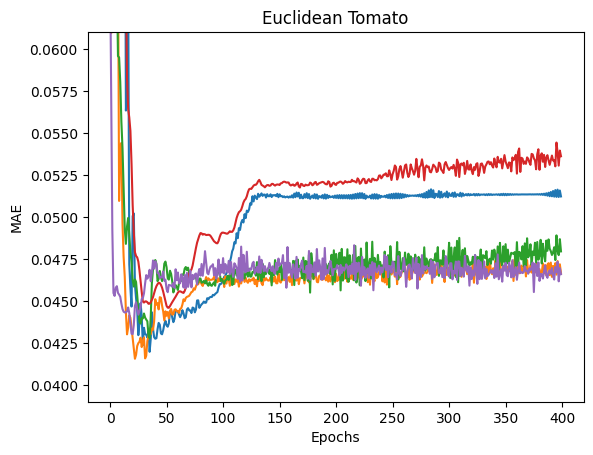

In [103]:
# hyp_min = (0, 1, -1)
# euc_min = (0, 1, -1)
# for i in range(28):
#     plt.plot(hyp_values.mean(axis=1)[i])
#     plt.plot(euc_values.mean(axis=1)[i])

#     print(i)
#     print(hyp_values.mean(axis=1)[i].min(), hyp_values.mean(axis=1)[i].argmin())
#     print(euc_values.mean(axis=1)[i].min(), euc_values.mean(axis=1)[i].argmin())

#     if hyp_values.mean(axis=1)[i].min() < hyp_min[1]:
#         hyp_min = (i, hyp_values.mean(axis=1)[i].min(), hyp_values.mean(axis=1)[i].argmin())
#     if euc_values.mean(axis=1)[i].min() < euc_min[1]:
#         euc_min = (i, euc_values.mean(axis=1)[i].min(), euc_values.mean(axis=1)[i].argmin())



for run in hyp_values.mean(axis=1)[[23, 32, 41, 40, 31]]:
    plt.plot(run)
    # plt.plot(run[20:])

plt.title('Hyperbolic Tomato')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.039,0.061)
# plt.yscale('log')
plt.show()


for run in euc_values.mean(axis=1)[[25, 14, 4, 1, 12]]:
    plt.plot(run)
    # plt.plot(run[20:])

plt.title('Euclidean Tomato')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.039,0.061)
# plt.yscale('log')
plt.show()
